In [1]:
from dataset import AirfoilDataset
import numpy as np
import pickle
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import turbine_data as turbine

In [2]:
alpha,_,_,_ = turbine.get_ClCd_from_file(0)

In [3]:
testing_airfoils = [17]
test_foil = DataLoader(AirfoilDataset(foils=testing_airfoils),batch_size=300)
test_foil_data = next(enumerate(test_foil))
_,(input,target) = test_foil_data
shape = input[1]
target = target.detach().numpy()

# Investigate performance
 * Get average loss per network, outside and inside physics and total.
 * Get std of loss

In [4]:
coefficients = ["Cl","Cd","Cm"]

In [5]:
doublerun = [["l6_i1","l6_i2","l6_i3","l6_i4","l6_i5","l6_i6"],
        ["l6_i1_nophys","l6_i2_nophys","l6_i3_nophys","l6_i4_nophys","l6_i5_nophys","l6_i6_nophys"]]

In [6]:
def get_predictions(source="long_train"):
    loss = {}
    result = {}
    for run in range(len(doublerun)):
        networks = doublerun[run]
        fname = [source+"/predictions.pickle",source+"/predictions_nophys.pickle"][run]
        with open(fname,"rb") as f:
            predictions = pickle.load(f)
        for architecture in networks:
            for c in range(3):
                coeff = coefficients[c]

                result[architecture,coeff] = []
                loss[architecture,coeff,"overall"] = []
                loss[architecture,coeff,"central"] = []
                loss[architecture,coeff,"outside"] = []
                
                for iteration in range(10):
                    
                    # store the result itself for nice plots later
                    result[architecture,coeff].append(predictions[architecture,iteration,coeff])
                    
                    # get the MSE on this iteration
                    l = ((predictions[architecture,iteration,coeff]-target[:,c])**2).mean()
                    loss[architecture,coeff,"overall"].append(l)

                    l = ((predictions[architecture,iteration,coeff][83:117]-target[:,c][83:117])**2).mean()
                    loss[architecture,coeff,"central"].append(l)
                    
                    l1 = ((predictions[architecture,iteration,coeff][:50] - target[:,c][:50])**2)
                    l2 = ((predictions[architecture,iteration,coeff][150:]-target[:,c][150:])**2)
                    loss[architecture,coeff,"outside"].append(np.concatenate((l1,l2)).mean())
                    
                loss[architecture,coeff,"overall","mean"] = np.array(loss[architecture,coeff,"overall"]).mean()
                loss[architecture,coeff,"central","mean"] = np.array(loss[architecture,coeff,"central"]).mean()
                loss[architecture,coeff,"outside","mean"] = np.array(loss[architecture,coeff,"outside"]).mean()
                loss[architecture,coeff,"overall","std"] = np.array(loss[architecture,coeff,"overall"]).std()
                loss[architecture,coeff,"central","std"] = np.array(loss[architecture,coeff,"central"]).std()
                loss[architecture,coeff,"outside","std"] = np.array(loss[architecture,coeff,"outside"]).std()

                for area in ["overall","central","outside"]:
                    loss[architecture,coeff,area,"max"] = np.array(loss[architecture,coeff,area]).max()
                    loss[architecture,coeff,area,"min"] = np.array(loss[architecture,coeff,area]).min()
                
                result[architecture,coeff] = np.array(result[architecture,coeff])
                result[architecture,coeff,"mean"] = np.mean(result[architecture,coeff],0)
                result[architecture,coeff,"std"] = np.std(result[architecture,coeff],0)
    return loss, result

In [7]:
networks = doublerun[0]+doublerun[1]

# Plot Loss

In [8]:
run = "epoch50lr01"

In [9]:
loss,result = get_predictions(run)
area = "overall"
layers = np.arange(1,7)
plt.rcParams["figure.figsize"] = [4,2]

## Kun gjennomsnitt

In [10]:
cost,result = get_predictions("epoch20lr01/")
print("Name".ljust(16),"overall ","central ","outside")
for architecture in networks:
    print((architecture+"_Cl").ljust(16)+" "+"{:.5f}  {:.5f}  {:.5f}".format(
        loss[architecture,"Cl","overall","mean"],
        loss[architecture,"Cl","central","mean"],
        loss[architecture,"Cl","outside","mean"]))

Name             overall  central  outside
l6_i1_Cl         0.05211  0.01453  0.09220
l6_i2_Cl         0.03472  0.00751  0.06143
l6_i3_Cl         0.02825  0.00316  0.05124
l6_i4_Cl         0.10661  0.00417  0.20645
l6_i5_Cl         0.14845  0.00358  0.28677
l6_i6_Cl         0.15164  0.01217  0.28839
l6_i1_nophys_Cl  0.10140  0.06450  0.05989
l6_i2_nophys_Cl  0.11040  0.07561  0.06750
l6_i3_nophys_Cl  0.01982  0.00373  0.03293
l6_i4_nophys_Cl  0.12099  0.07765  0.08755
l6_i5_nophys_Cl  0.65150  0.51239  0.23382
l6_i6_nophys_Cl  0.86777  0.62355  0.33471


In [11]:
loss,result = get_predictions("epoch50lr01/")
for area in ["overall","central","outside"]: 
    for par in ["mean","std","min","max"]:
        loss["l6_i3_nophys","Cl",area,par] = cost["l6_i3_nophys","Cl",area,par]    

## +- std

In [12]:
#loss,result = get_predictions("epoch50lr01/")
print("Name".ljust(9),"  overall ","               central ","               outside")
for architecture in networks:
    print("Layer "+architecture[4]+" & "+"{:.5f} $\pm$ {:.5f} & {:.5f} $\pm$ {:.5f} & {:.5f} $\pm$ {:.5f} \\\\".format(
        loss[architecture,"Cl","overall","mean"],loss[architecture,"Cl","overall","std"],
        loss[architecture,"Cl","central","mean"],loss[architecture,"Cl","central","std"],
        loss[architecture,"Cl","outside","mean"],loss[architecture,"Cl","outside","std"]))

Name        overall                 central                 outside
Layer 1 & 0.05211 $\pm$ 0.04191 & 0.01453 $\pm$ 0.01471 & 0.09220 $\pm$ 0.08414 \\
Layer 2 & 0.03472 $\pm$ 0.03205 & 0.00751 $\pm$ 0.00866 & 0.06143 $\pm$ 0.05962 \\
Layer 3 & 0.02825 $\pm$ 0.01914 & 0.00316 $\pm$ 0.00227 & 0.05124 $\pm$ 0.03736 \\
Layer 4 & 0.10661 $\pm$ 0.05086 & 0.00417 $\pm$ 0.00817 & 0.20645 $\pm$ 0.10113 \\
Layer 5 & 0.14845 $\pm$ 0.00354 & 0.00358 $\pm$ 0.00387 & 0.28677 $\pm$ 0.00475 \\
Layer 6 & 0.15164 $\pm$ 0.00125 & 0.01217 $\pm$ 0.00245 & 0.28839 $\pm$ 0.00147 \\
Layer 1 & 0.10140 $\pm$ 0.25600 & 0.06450 $\pm$ 0.18477 & 0.05989 $\pm$ 0.09839 \\
Layer 2 & 0.11040 $\pm$ 0.25390 & 0.07561 $\pm$ 0.18422 & 0.06750 $\pm$ 0.09762 \\
Layer 3 & 0.06989 $\pm$ 0.08548 & 0.07136 $\pm$ 0.07608 & 0.07257 $\pm$ 0.07093 \\
Layer 4 & 0.12099 $\pm$ 0.24941 & 0.07765 $\pm$ 0.18171 & 0.08755 $\pm$ 0.08431 \\
Layer 5 & 0.65150 $\pm$ 0.19689 & 0.51239 $\pm$ 0.09286 & 0.23382 $\pm$ 0.09206 \\
Layer 6 & 0.86777 $

## min < avg < max

In [85]:
#loss,result = get_predictions("epoch50lr01/")
print("Name".ljust(9),"            overall ","                       central ","                       outside")
for architecture in networks:
    print("Layer "+architecture[4]+" &   "+"{:.5f} < {:.5f} < {:.5f} &   {:.5f} < {:.5f} < {:.5f} &   {:.5f} < {:.5f} < {:.5f} &    \\\\".format(
        loss[architecture,"Cl","overall","min"],loss[architecture,"Cl","overall","mean"],loss[architecture,"Cl","overall","max"],
        loss[architecture,"Cl","central","min"],loss[architecture,"Cl","central","mean"],loss[architecture,"Cl","central","max"],
        loss[architecture,"Cl","outside","min"],loss[architecture,"Cl","outside","mean"],loss[architecture,"Cl","outside","max"]))

Name                  overall                         central                         outside
Layer 1 &   0.01771 < 0.05211 < 0.14254 &   0.00108 < 0.01453 < 0.04712 &   0.02923 < 0.09220 < 0.27382 &    \\
Layer 2 &   0.01486 < 0.03472 < 0.12883 &   0.00090 < 0.00751 < 0.02525 &   0.02424 < 0.06143 < 0.23695 &    \\
Layer 3 &   0.01004 < 0.02825 < 0.08054 &   0.00083 < 0.00316 < 0.00787 &   0.01617 < 0.05124 < 0.15334 &    \\
Layer 4 &   0.01860 < 0.10661 < 0.14698 &   0.00038 < 0.00417 < 0.02859 &   0.03400 < 0.20645 < 0.28512 &    \\
Layer 5 &   0.13975 < 0.14845 < 0.15226 &   0.00007 < 0.00358 < 0.00989 &   0.27448 < 0.28677 < 0.29116 &    \\
Layer 6 &   0.15036 < 0.15164 < 0.15480 &   0.00887 < 0.01217 < 0.01802 &   0.28660 < 0.28839 < 0.29141 &    \\
Layer 1 &   0.00925 < 0.10140 < 0.86929 &   0.00034 < 0.06450 < 0.61877 &   0.01424 < 0.05989 < 0.35376 &    \\
Layer 2 &   0.00649 < 0.11040 < 0.86964 &   0.00116 < 0.07561 < 0.61788 &   0.00911 < 0.06750 < 0.35456 &    \\
Layer 3 & 

## gjennomsnitt - største spredning

In [86]:
#loss,result = get_predictions("epoch50lr01/")
print("Name".ljust(9),"  overall ","               central ","               outside")
for architecture in networks:
    print("Layer "+architecture[4]+" &   "+"{:.5f} \in {:.5f} &   {:.5f} \in {:.5f} &   {:.5f} \in {:.5f} &    \\\\".format(
        loss[architecture,"Cl","overall","mean"],loss[architecture,"Cl","overall","max"]-loss[architecture,"Cl","overall","min"],
        loss[architecture,"Cl","central","mean"],loss[architecture,"Cl","central","max"]-loss[architecture,"Cl","central","min"],
        loss[architecture,"Cl","outside","mean"],loss[architecture,"Cl","outside","max"]-loss[architecture,"Cl","outside","min"]))

Name        overall                 central                 outside
Layer 1 &   0.05211 \in 0.12484 &   0.01453 \in 0.04604 &   0.09220 \in 0.24459 &    \\
Layer 2 &   0.03472 \in 0.11397 &   0.00751 \in 0.02435 &   0.06143 \in 0.21271 &    \\
Layer 3 &   0.02825 \in 0.07050 &   0.00316 \in 0.00703 &   0.05124 \in 0.13718 &    \\
Layer 4 &   0.10661 \in 0.12837 &   0.00417 \in 0.02821 &   0.20645 \in 0.25112 &    \\
Layer 5 &   0.14845 \in 0.01251 &   0.00358 \in 0.00982 &   0.28677 \in 0.01669 &    \\
Layer 6 &   0.15164 \in 0.00444 &   0.01217 \in 0.00915 &   0.28839 \in 0.00481 &    \\
Layer 1 &   0.10140 \in 0.86003 &   0.06450 \in 0.61843 &   0.05989 \in 0.33952 &    \\
Layer 2 &   0.11040 \in 0.86315 &   0.07561 \in 0.61672 &   0.06750 \in 0.34545 &    \\
Layer 3 &   0.06989 \in 0.29623 &   0.07136 \in 0.24875 &   0.07257 \in 0.25590 &    \\
Layer 4 &   0.12099 \in 0.84093 &   0.07765 \in 0.61863 &   0.08755 \in 0.28928 &    \\
Layer 5 &   0.65150 \in 0.55102 &   0.51239 \in 0.27

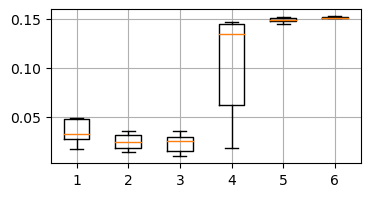

In [87]:
_ = plt.boxplot(np.array([loss[architecture,"Cl","overall"] for architecture in networks[:6]]).T,showfliers=False)
plt.grid()
#plt.ylim([0,0.05])

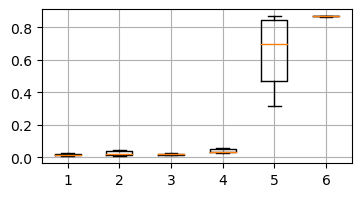

In [88]:
_=plt.boxplot(np.array([loss[architecture,"Cl","overall"] for architecture in networks[6:]]).T,showfliers=False)
plt.grid()

In [33]:
for area in ["overall","central","outside"]: 
    print(np.mean([loss[architecture,"Cl",area,"mean"] for architecture in networks[:6]]))

0.08696616
0.0075187213
0.16441387


In [91]:
for area in ["overall","central","outside"]: 
    print(np.mean([loss[architecture,"Cl",area,"std"] for architecture in networks[6:]]))

0.17364039
0.1203832
0.07435128


### Plot architecture and coefficient with uncertainty bound

............

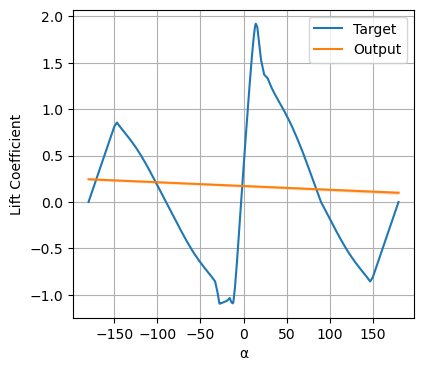

In [148]:
loss,result = get_predictions(run)
plt.rcParams["figure.figsize"] = [4.4,4]
plt.rcParams['text.usetex'] = False
for architecture in networks:
    for c in range(1):
        print(".",end='')
        coeff = coefficients[c]
        cname = ["Lift Coefficient","Drag Coefficient","Coefficient of Moment"][c]
        mean = result[architecture,coeff,"mean"]
        stddev = result[architecture,coeff,"std"]
        upper_bound = mean + stddev
        lower_bound = mean - stddev
        plt.close()
        plt.plot(alpha,target[:,c])
        plt.plot(alpha,mean)
        plt.fill_between(alpha,lower_bound,upper_bound,alpha=0.2,color="tab:orange")
        plt.legend(["Target","Output"])
        plt.xlabel("α")
        plt.ylabel(cname)
        plt.grid()
        filename = run+"/"+architecture+"_"+coeff+".pdf"
        plt.savefig(filename,bbox_inches="tight")

# XFOIL performance

XFOIL error: 0.057409793


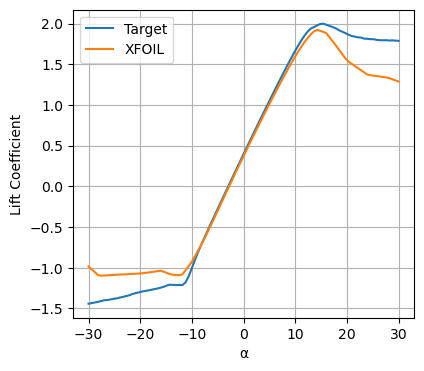

In [219]:
plt.rcParams["figure.figsize"] = [4.4,4]
tarcl = target[50:150,0]
xfoil = input[2][50:150,0].detach().numpy()
lo = -1.5716
hi = 2.3858
xfoil = 0.5*(xfoil+1)*(hi-lo)+lo
plt.plot(alpha[50:150],xfoil)
plt.plot(alpha[50:150],tarcl)
print("XFOIL error:",((tarcl-xfoil)**2).mean())
plt.legend(["Target","XFOIL"])
plt.xlabel("α")
plt.ylabel(cname)
plt.grid()
#filename = run+"/"+architecture+"_"+coeff+".pdf"
#plt.savefig(filename,bbox_inches="tight")